# Project Machine Learning 2023
Dionysios Voulgarakis, \
December 2023
* <a href = "Project-Machine Learning and Computational Statistics.pdf"> Find project Here</a>

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import scipy.optimize 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, neighbors, linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import metrics

# Part 1: Spectral Unmixing

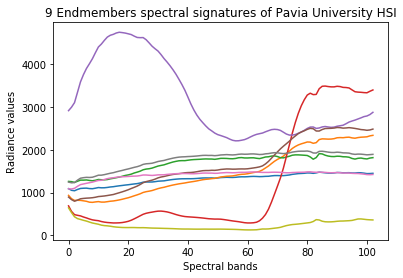

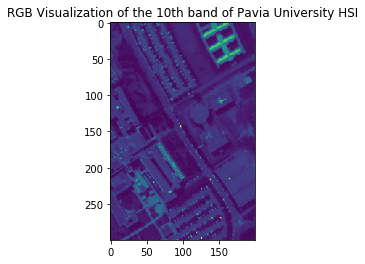

In [33]:
#Load data
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

HSI contains the image.(300x200x103). We will keep only perform unmixing for the HSI where labels are > 0.

In [34]:
HSI_copy = HSI

In [35]:
# Taking the nonzero labels
non_zero =HSI[np.where(labels > 0)]
non_zero.shape

(12829, 103)

## Least Squares

$y = X \theta + \eta$ \
HSI = endsmembers * theta + eta

In [36]:
# Perform least squares
theta_ls = np.linalg.inv(endmembers.T@endmembers) @endmembers.T @ non_zero.T
y_ls = np.dot(endmembers,theta_ls)

In [37]:
print(f'Theta in [{np.min(theta_ls):.2f},{np.max(theta_ls):.2f}]')

Theta in [-22.64,17.11]


In [38]:
# Recosnstruction error
error_ls = np.linalg.norm(y_ls.T - non_zero, axis=1)**2
print(f'Mean reconstruction error: {np.mean(error_ls):.2f}')

Mean reconstruction error: 118783.18


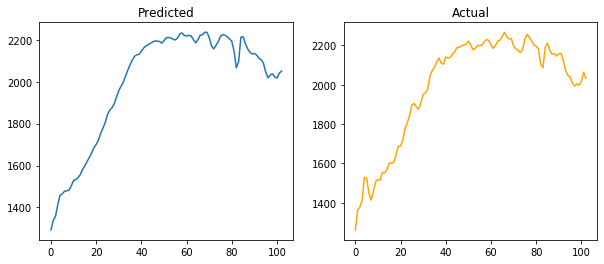

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot on the predicted pixel 
axs[0].plot(y_ls[:,11])
axs[0].set_title('Predicted');

axs[1].plot(non_zero[11], color='orange');  
axs[1].set_title('Actual')

plt.show()

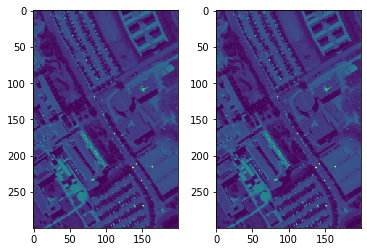

In [51]:
# Put back the non_zero labels
mask = labels > 0
HSI_copy[mask] = y_ls.T

fig, ax = plt.subplots(1,2)
ax[0].imshow(HSI[:,:,50])
ax[1].imshow(HSI_copy[:,:,50])

## Least Squares with non-negative coefficients

We will use the nnls function for this purpose.

In [44]:
from scipy.optimize import nnls

theta_nn = np.zeros((non_zero.shape[0],9))
for i in range(12829):
            theta_nn[i], _ = nnls(endmembers,non_zero[i,:])

y_nn = np.dot(endmembers,theta_nn.T)

In [45]:
print(f'Theta in [{np.min(theta_nn):.2f},{np.max(theta_nn):.2f}]')

Theta in [0.00,3.15]


In [46]:
error_nn = np.linalg.norm(y_nn.T - non_zero, axis=1)**2
print(f'Mean reconstruction error: {np.mean(error_nn):.2f}')

Mean reconstruction error: 569339.29


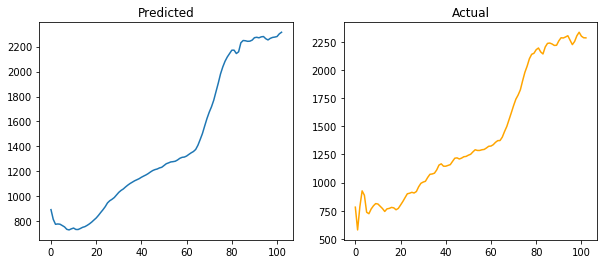

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot on the predicted pixel 
axs[0].plot(y_nn[:,19])
axs[0].set_title('Predicted');


axs[1].plot(non_zero[19], color='orange');  
axs[1].set_title('Actual')

plt.show()

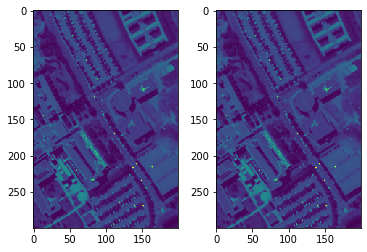

In [49]:
# Put back the non_zero labels
mask = labels > 0
HSI_copy[mask] = y_nn.T

fig, ax = plt.subplots(1,2)
ax[0].imshow(HSI[:,:,50])
ax[1].imshow(HSI_copy[:,:,50])


## Least Squares with coefficients sum to one

We will perform least squares, with constraint the coefficients to sum to 1.

In [52]:
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor

A = endmembers
B = non_zero
theta_sum = np.zeros((12829,9))


# Objective function for least squares
def objective(c, A, b):
    return np.dot((A.dot(c) - b).T, A.dot(c) - b)

# Constraint function for the sum of coefficients equal to 1
def constraint(c):
    return np.sum(c) - 1

#Optimize for each pixel and get thetas
def optimize_for_set(i):
    current_y = non_zero[i]
    #make initial guess
    initial_guess,_ = nnls(A,current_y)
    constraints = ({'type': 'eq', 'fun': constraint})
    #minimize
    result = minimize(objective, initial_guess, args=(A, current_y), constraints=constraints)
    theta_sum[i] = result.x

#ThreadPoolExecutor for parallel optimization
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(optimize_for_set, range(12829)))


In [13]:
print(f'Sum of thetas of a random pixel : {np.sum(theta_sum[17])}')

Sum of thetas of a random pixel : 0.9999999999999996


In [14]:
print(f'Theta in [{np.min(theta_sum):.2f},{np.max(theta_sum):.2f}]')

Theta in [-30.73,21.21]


In [55]:
# Calculate y
y_sum = np.dot(endmembers,theta_sum.T)

In [56]:
# Recosnstruction error
error_sum = np.linalg.norm(y_sum.T - non_zero, axis=1)**2
print(f'Mean reconstruction error: {np.mean(error_sum):.2f}')

Mean reconstruction error: 160049.93


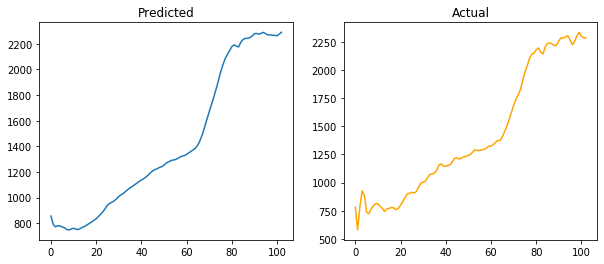

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot on the predicted pixel 
axs[0].plot(y_sum[:,19])
axs[0].set_title('Predicted');


axs[1].plot(non_zero[19], color='orange');  
axs[1].set_title('Actual')

plt.show()

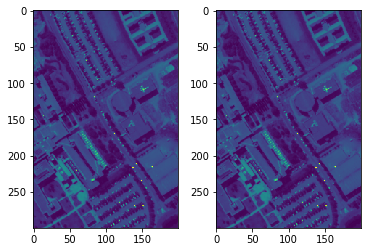

In [59]:
# Put back the non_zero labels
mask = labels > 0
HSI_copy[mask] = y_sum.T

fig, ax = plt.subplots(1,2)
ax[0].imshow(HSI[:,:,50])
ax[1].imshow(HSI_copy[:,:,50])

## Least Squares with non negative coefficients sum to one

For the purposes of efficiency, we using less rigit bound on negativity. Thus we can have some thetas to be negative, but very close to 0.

In [18]:
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor

A = endmembers
B = non_zero
theta_nn_sum = np.zeros((12829,9))


# Objective function for least squares
def objective(c, A, b):
    return np.dot((A.dot(c) - b).T, A.dot(c) - b)


# Constraint function for the sum of coefficients equal to 1
def constraint(c):
    return np.sum(c) - 1

bounds = [(0, None)] * 9 # Bounds: coefficients should be greater than or equal to 0

# Optimize for each pixel and get thetas
def optimize_for_set(i):
    
    current_y = non_zero[i]
    initial_guess = theta_nn[i]
    constraints = ({'type': 'eq', 'fun': constraint})
    result = minimize(objective, initial_guess, args=(A, current_y), bounds=bounds, constraints=constraints,
                      method='trust-constr',options={'maxiter': 25})
    theta_nn_sum[i] = result.x

#ThreadPoolExecutor for parallel optimization
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(optimize_for_set, range(12829)))


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [19]:
print(f'Sum of thetas of a random pixel : {np.sum(theta_nn_sum[17])}')

Sum of thetas of a random pixel : 1.0


In [20]:
print(f'Theta_nn_sum in [{np.min(theta_nn_sum):.2f},{np.max(theta_nn_sum):.2f}]')

Theta_nn_sum in [-0.00,1.00]


In [21]:
# Calculate y
y_nn_sum = np.dot(endmembers,theta_nn_sum.T)

In [22]:
#recosnstruction error
error_nn_sum = np.linalg.norm(y_nn_sum.T - non_zero, axis=1)**2
print(f'Mean reconstruction error: {np.mean(error_nn_sum):.2f}')

Mean reconstruction error: 10344372.48


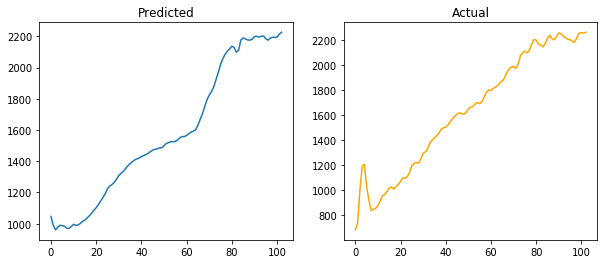

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot on the predicted pixel 
axs[0].plot(y_nn_sum[:,25])
axs[0].set_title('Predicted');


axs[1].plot(non_zero[25], color='orange');  
axs[1].set_title('Actual')

plt.show()

# LASSO Regression

In [24]:
from sklearn import linear_model
import warnings
warnings.filterwarnings(action='ignore')

clf = linear_model.Lasso(alpha=1,fit_intercept=False,max_iter=5000)

clf.fit(endmembers, non_zero.T)  # Transpose non_zero matrix to iterate over columns
y_lasso = clf.predict(endmembers).T
theta_lasso = clf.coef_.T

In [25]:
print(f'Theta_lasso in [{np.min(theta_lasso):.2f},{np.max(theta_lasso):.2f}]')

Theta_lasso in [-5.71,3.83]


In [26]:
error_lasso = np.linalg.norm(y_lasso - non_zero, axis=1)**2
print(f'Mean reconstruction error: {np.mean(error_lasso):.2f}')

Mean reconstruction error: 167194.78


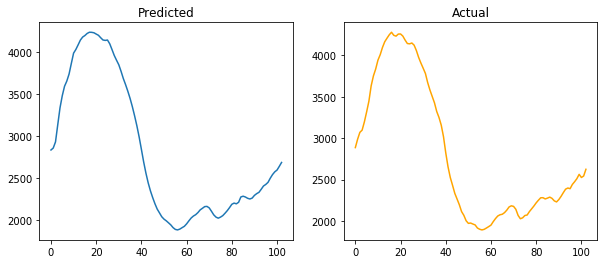

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed

# Plot on the predicted pixel 
axs[0].plot(y_lasso[40])
axs[0].set_title('Predicted');


axs[1].plot(non_zero[40], color='orange');  
axs[1].set_title('Actual')

plt.show()

## Results

* Reconstruction Error:
    * In general we see that the more the constraints the more the reconstruction error.
    * Simple LS is the best performing model with respect to reconstruction error.
    * Both models constrained with non-negativity are performing worse than the others
    * Model with non negativity and sum of coefficients to 1, is the worst.
* Coefficients:
    * In general the more unconstraint the model the more spread are the values of coefficients.
    * Simple LS coefs $\in$ [-22.64,17.11]
    * Non Negative coefs $\in$ [0.00,3.15]
    * Sum to one coefs $\in$ [-30.73,21.21]
    * Non Negative and sum to 1 coefs $\in$ [-0.00,1.00]
    * Lasso coefs $\in$ [-5.71,3.83]
* Fit:
    *If we dont insert any constraint to the model, result to overfitting
    *If we put many constraints to the model, result to undefitting
* Lets Visualize the above results.

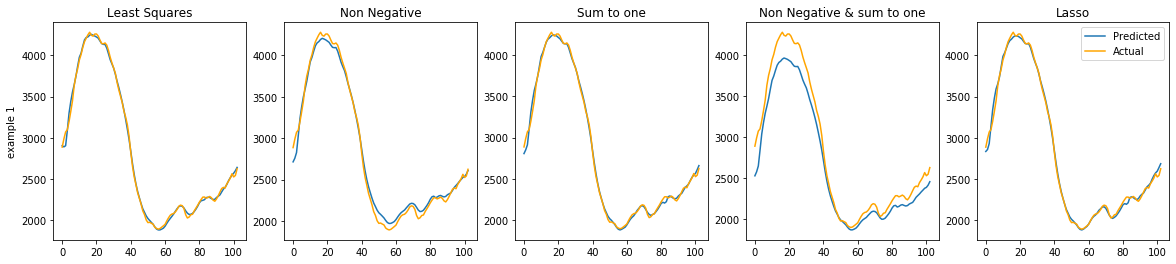

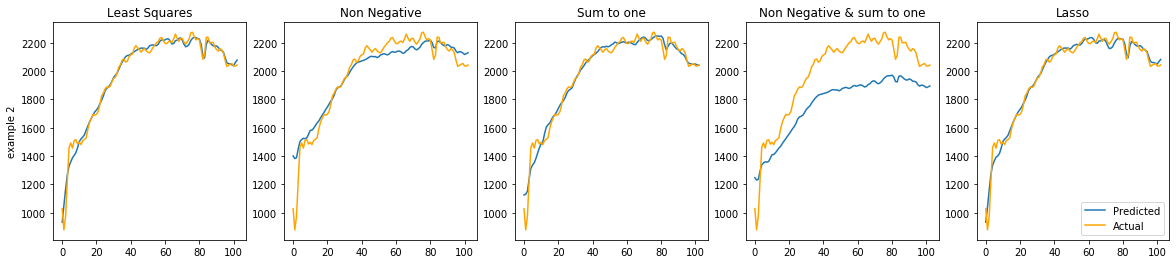

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  

axs[0].plot(y_ls[:,40],label='Predicted')
axs[0].plot(non_zero[40], color='orange',label='Actual')
axs[0].set_title('Least Squares');
axs[0].set_ylabel('example 1')

axs[1].plot(y_nn[:,40],label='Predicted')
axs[1].plot(non_zero[40], color='orange',label='Actual')
axs[1].set_title('Non Negative');

axs[2].plot(y_sum[:,40],label='Predicted')
axs[2].plot(non_zero[40], color='orange',label='Actual')
axs[2].set_title('Sum to one');

axs[3].plot(y_nn_sum[:,40],label='Predicted')
axs[3].plot(non_zero[40], color='orange',label='Actual')
axs[3].set_title('Non Negative & sum to one');

axs[4].plot(y_lasso[40],label='Predicted')
axs[4].plot(non_zero[40], color='orange',label='Actual');  
axs[4].set_title('Lasso')
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))  

axs[0].plot(y_ls[:,60],label='Predicted')
axs[0].plot(non_zero[60], color='orange',label='Actual')
axs[0].set_title('Least Squares');
axs[0].set_ylabel('example 2')

axs[1].plot(y_nn[:,60],label='Predicted')
axs[1].plot(non_zero[60], color='orange',label='Actual')
axs[1].set_title('Non Negative');

axs[2].plot(y_sum[:,60],label='Predicted')
axs[2].plot(non_zero[60], color='orange',label='Actual')
axs[2].set_title('Sum to one');

axs[3].plot(y_nn_sum[:,60],label='Predicted')
axs[3].plot(non_zero[60], color='orange',label='Actual')
axs[3].set_title('Non Negative & sum to one');

axs[4].plot(y_lasso[60],label='Predicted')
axs[4].plot(non_zero[60], color='orange',label='Actual');  
axs[4].set_title('Lasso')
plt.legend()

plt.show()

# Classification

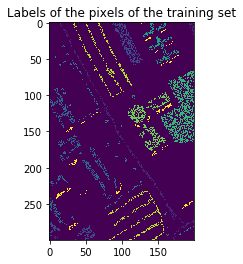

In [29]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [30]:
# Counts per category
unique, counts = np.unique(Training_Set, return_counts=True)
print(unique,counts)

[0 1 2 3 4 5 6 7 8 9] [53585   575   698  1013   296   359  1512   678   889   395]


Lets again take the set where labels are non zero.

In [31]:
#Take the non zero labels for train
train_Y = Training_Set[np.where(Training_Set>0)]
train_X = HSI[np.where(Training_Set>0)]

In [32]:
#Take the non zero labels for test
test_Y = Test_Set[np.where(Test_Set>0)]
test_X = HSI[np.where(Test_Set>0)]

## K- Neighbors Classifier

We will run a gridsearch, will some parameters and 10-fold cross validation. Re-train automatically to the whole dataset with the best estimator.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1,2,5,10,20],
    'weights':['uniform', 'distance']
}

# Perform cross validation for different parameters, refit automatically to whole dataset after the cross val
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, refit = True, verbose = 0,iid=True) 
grid_knn = grid_knn.fit(train_X,train_Y)

print(grid_knn.best_estimator_)

# Find the index of the best parameters
best_index = grid_knn.best_index_ 
print(f'Average error: {1-grid_knn.cv_results_["mean_test_score"][best_index]:.3f}')
print(f'Average std : {grid_knn.cv_results_["std_test_score"][best_index]:.3f}')                             


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
Average error: 0.145
Average std : 0.051


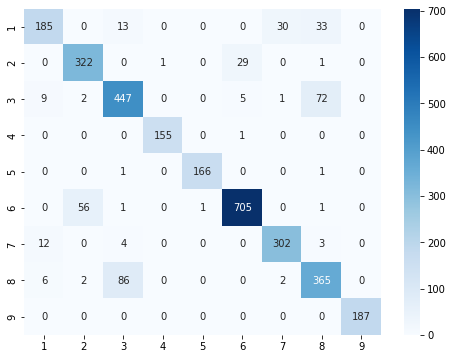

In [34]:
y_pred = grid_knn.best_estimator_.predict(test_X)

#sklearn.metrics confusion matrix
cm = confusion_matrix(test_Y, y_pred)

ticks =np.linspace(1,9,9).astype(int)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True,cmap='Blues',fmt='d',xticklabels=ticks, yticklabels=ticks)
plt.show()

In [35]:
# Success rate diagonal/all
print(f'Success rate: {cm.diagonal().sum()/np.sum(cm):.3f}')

Success rate: 0.884


In [36]:
# Find the missclassified elements for each class. They are the non-diagonal elements for each row.
miss = pd.Series(np.sum(cm - np.eye(cm.shape[0], dtype=int)*cm, axis=1),index=ticks)
print('Top 5 classes with most missclassificated elements')

miss.sort_values(ascending=False).head(5)

Top 5 classes with most missclassificated elements


8    96
3    89
1    76
6    59
2    31
dtype: int64

## Minumun Euclidean Distance Classifier

In [37]:
from sklearn.model_selection import StratifiedKFold

num_folds = 10

# Initialize the StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Create an array to store the predictions for each fold
y_pred_eu = np.zeros_like(train_Y)  
error = np.array([])

# Loop through each fold
for train_index, test_index in kf.split(train_X, train_Y):  
    X_train, X_val = train_X[train_index], train_X[test_index]
    y_train, y_val = train_Y[train_index], train_Y[test_index]

    #Take the mean for each class
    mus = []
    for i in range(9):
        mus.append(np.mean(X_train[np.where(y_train==i+1)], axis=0))
    
    mus = np.array(mus)
    
    # Predict the class with the least distance from x
    y_pred_fold = []
    for i in range(X_val.shape[0]):
        y_pred_fold.append(np.argmin([np.linalg.norm(X_val[i] - mean) for mean in mus]) + 1)

    # Store the predictions for this fold
    y_pred_eu[test_index] = np.array(y_pred_fold)
    error = np.append(error, 1- accuracy_score(y_val, y_pred_fold))
    
print(f'Average error: {np.mean(error):.3f}')
print(f'Average std: {np.std(error):.3f}')


Average error: 0.434
Average std: 0.014


Now train the whole dataset.

In [38]:
# Find the mean for each class
mus = []
for i in range(9):
    mus.append(np.mean(train_X[np.where(train_Y==i+1)], axis=0))
    
mus = np.array(mus)

In [39]:
# Predict y
y_pred_eu = []

for i in range(test_X.shape[0]):
    y_pred_eu.append(np.argmin([np.linalg.norm(test_X[i] - mean) for mean in mus])+1)

y_pred = np.array(y_pred)

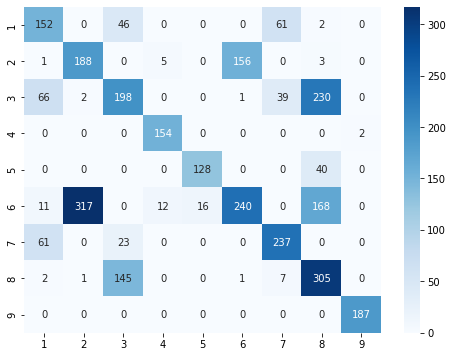

In [40]:
cm = confusion_matrix(test_Y, y_pred_eu)

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot = True,cmap='Blues',fmt='d',xticklabels=ticks, yticklabels=ticks)

In [41]:
# Success rate diagonal/all
print(f'Success rate: {cm.diagonal().sum()/np.sum(cm):.3f}')

Success rate: 0.558


In [42]:
# Find the missclassified elements for each class. They are the non-diagonal elements for each row.
miss = pd.Series(np.sum(cm - np.eye(cm.shape[0], dtype=int)*cm, axis=1),index=ticks)
print('Top 5 classes with most missclassificated elements')
miss.sort_values(ascending=False).head(5)

Top 5 classes with most missclassificated elements


6    524
3    338
2    165
8    156
1    109
dtype: int64

## Naive Bayes Classifier

In [43]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [0.0001,0.0005,0.01,0.05,0.1,0.2, 0.5, 1.0, 1.5, 2.0],
}

# Refit automatically to whole dataset after cross validation
grid_nb = GridSearchCV(MultinomialNB(fit_prior=True), param_grid, cv=10, refit = True, verbose = 0,iid=True) 
grid_nb = grid_nb.fit(train_X,train_Y)
print(grid_nb.best_estimator_)

# Find the index of the best parameters
best_index = grid_nb.best_index_ 
print(f'Average error: {1-grid_nb.cv_results_["mean_test_score"][best_index]:.3f}')
print(f'Average std : {grid_nb.cv_results_["std_test_score"][best_index]:.3f}')        

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
Average error: 0.407
Average std : 0.068


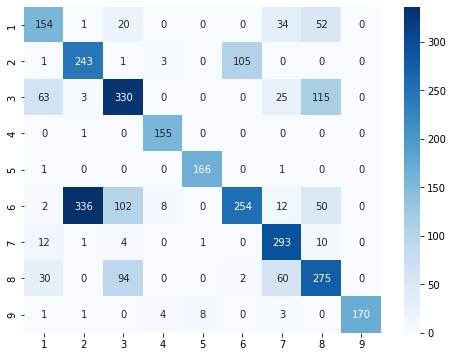

In [44]:
y_pred = grid_nb.best_estimator_.predict(test_X)

cm = confusion_matrix(test_Y, y_pred)
accuracy = accuracy_score(test_Y, y_pred)

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot = True,cmap='Blues',fmt='d',xticklabels=ticks, yticklabels=ticks)

In [45]:
# Find the missclassified elements for each class. They are the non-diagonal elements for each row.
miss = pd.Series(np.sum(cm - np.eye(cm.shape[0], dtype=int)*cm, axis=1),index=ticks)
print('Top 5 classes with most missclassificated elements')
miss.sort_values(ascending=False).head(5)

Top 5 classes with most missclassificated elements


6    510
3    206
8    186
2    110
1    107
dtype: int64

In [46]:
# Fuccess rate diagonal/all
print(f'Success rate: {cm.diagonal().sum()/np.sum(cm):.3f}')

Success rate: 0.636


## Bayesian Classifier

We will predict based on bayes classifier. We will use parzen windows to compute the p_x_w's.

First we will scale the data, in order to have better parzen windows calculation.

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [48]:
def parzen_window(x, X, h):
    return np.sum(np.exp(-np.sum((X - x)**2, axis=1) / (2 * h**2))) / (len(X) * h**2)

Now we will do 10 fold cross validation.

In [49]:
from sklearn.model_selection import KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

errors = []

# Perform 10-fold cross-validation
for train_index, val_index in kf.split(train_X_scaled):
    x_train, x_val = train_X_scaled[train_index], train_X_scaled[val_index]
    y_train, y_val = train_Y[train_index], train_Y[val_index]
    
    
    #calculate priors  
    unique, frequency = np.unique(y_train, 
                              return_counts = True)
    priors = np.zeros(9)
    for i in range(len(priors)):
        priors[i] = frequency[i]/frequency.sum()
    

    y_pred = []
    for j in range(x_val.shape[0]):
        p_x_w = []
        for i in range(9):
            p_x_w.append(parzen_window(x_val[j],x_train[np.where(y_train==i+1)], h=0.2))
    
        #classify to the most probable class
        y_pred.append(np.argmax(p_x_w*priors)+1)
    y_pred = np.array(y_pred)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_val, y_pred)
    errors.append(1-accuracy)

# Print the average accuracy across all folds
average_error = sum(errors) / num_folds
print(f'Average error: {average_error:.3f}')
print(f'Average std: {average_error:.3f}')

Average error: 0.121
Average std: 0.121


Train to whole dataset

In [50]:
unique, frequency = np.unique(train_Y, return_counts = True)

# Calculate priors of the whole train set
priors = np.zeros(9)
for i in range(len(priors)):
    priors[i] = frequency[i]/frequency.sum()

In [51]:
# Predict test
h=0.2
y_pred = []
for j in range(test_Y.shape[0]):
    p_x_w = []
    for i in range(9):
        p_x_w.append(parzen_window(test_X_scaled[j],train_X_scaled[np.where(train_Y==i+1)], h))
    
    y_pred.append(np.argmax(p_x_w*priors)+1)
y_pred = np.array(y_pred)

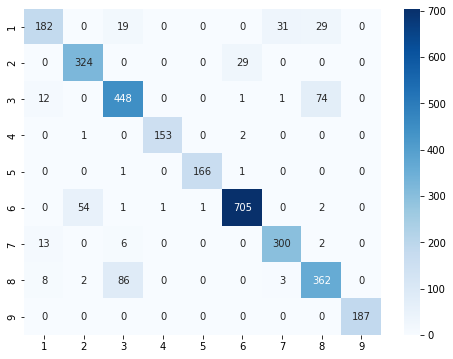

In [52]:
# Confusion matrix
cm = confusion_matrix(test_Y, y_pred)
accuracy = accuracy_score(test_Y, y_pred)

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot = True,cmap='Blues',fmt='d',xticklabels=ticks, yticklabels=ticks)

In [53]:
# Find the missclassified elements for each class. They are the non-diagonal elements for each row.
miss = pd.Series(np.sum(cm - np.eye(cm.shape[0], dtype=int)*cm, axis=1),index=ticks)
print('Top 5 classes with most missclassificated elements')

miss.sort_values(ascending=False).head(5)

Top 5 classes with most missclassificated elements


8    99
3    88
1    79
6    59
2    29
dtype: int64

In [54]:
# Success rate diagonal/all
print(f'Success rate: {cm.diagonal().sum()/np.sum(cm):.3f}')

Success rate: 0.882


## Results
* Best Performing Models was Knn and Bayessian Classifier.
* Class 8 is confused with class 3 in all models.
* Class 6 is confused with class 2 in all models.

# Part 1 and 2 combined

Lets visualize the classes of Part2 where our model were confused. These classes are 2 with 6, and 3 with 8.

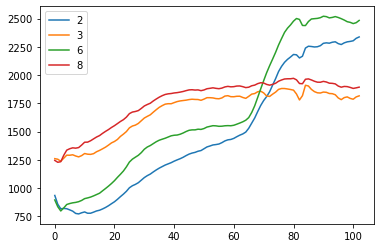

In [55]:
plt.plot(endmembers[:,1],label='2')
plt.plot(endmembers[:,2],label='3')
plt.plot(endmembers[:,5],label='6')
plt.plot(endmembers[:,7],label='8')

plt.legend()
plt.show()

We see that their spectrums are follow close to identical patterns. So it make sense our models have a difficult time distinguish them.